In [4]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing your images
image_dir = './documents'  # Directory with original images
preprocessed_dir = './documents/preprocessed_images'  # Directory to save preprocessed images

# Ensure the preprocessed images directory exists
os.makedirs(preprocessed_dir, exist_ok=True)

# List all files in the directory
image_files = os.listdir(image_dir)

# Open each image file and convert to grayscale
images = [(file, Image.open(os.path.join(image_dir, file)).convert('L')) for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]

# Preprocessing parameters
left = 232
top = 60
img_width = 495
img_height = 475
right = left + img_width
bottom = top + img_height

# Preprocess images
cropped_images = [(file, img.crop((left, top, right, bottom))) for file, img in images]

# Convert to numpy arrays
cv_images = [(file, np.array(image)) for file, image in cropped_images]

# Define constants
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
MAX_DELTA = 200
crop_top = 290
crop_height = 100
crop_bottom = crop_top + crop_height
crop_left = 215
crop_width = 125
crop_right = crop_left + crop_width
MIN_DELTA_X = -crop_left
MAX_DELTA_X = img_width - crop_right
MIN_DELTA_Y = -crop_top
MAX_DELTA_Y = img_height - crop_bottom

from sklearn.cluster import DBSCAN

cluster_model = DBSCAN(eps=10, min_samples=5)

def alignImages(im1, im2):
    try:
        if len(im1.shape) == 3:
            im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        else:
            im1Gray = im1
            im2Gray = im2

        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = list(matcher.match(descriptors1, descriptors2, None))

        matches.sort(key=lambda x: x.distance, reverse=False)
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        matches = matches[:numGoodMatches]

        if not matches:
            print("No good matches found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], None

        match_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        deltas = np.zeros((len(matches), 2))
        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt
            deltas[i] = points2[i] - points1[i]

        deltas = deltas[np.where((deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y))]

        if len(deltas) == 0:
            print("No valid deltas found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image

        associations = cluster_model.fit_predict(deltas)
        clusters = np.unique(associations)
        cluster_points = np.where(associations == 0)
        offset = np.average(deltas[cluster_points], axis=0)

        return offset, deltas, cluster_points, match_image
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Prepare image dataset
image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)

for i, (filename, image) in enumerate(cv_images):
    offset_left, offset_top = alignImages(cv_images[0][1], image)[0]

    if np.isnan(offset_left) or np.isnan(offset_top):
        print(f"Invalid offsets for image {i}: offset_left={offset_left}, offset_top={offset_top}")
        continue

    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)

    if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
        cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
        image_dataset[i] = cropped_image
        # Save preprocessed image with the original filename
        preprocessed_path = os.path.join(preprocessed_dir, filename)
        Image.fromarray(cropped_image).save(preprocessed_path)
    else:
        print(f"Cropping out of bounds for image {i}: cropped_top={cropped_top}, cropped_bottom={cropped_bottom}, cropped_left={cropped_left}, cropped_right={cropped_right}")

print(image_dataset.shape)


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Ex

Invalid offsets for image 8: offset_left=nan, offset_top=nan
Invalid offsets for image 10: offset_left=nan, offset_top=nan
Invalid offsets for image 13: offset_left=nan, offset_top=nan
Invalid offsets for image 15: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 57: offset_left=nan, offset_top=nan
Invalid offsets for image 66: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 82: offset_left=nan, offset_top=nan
Invalid offsets for image 86: offset_left=nan, offset_top=nan
Invalid offsets for image 87: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 100: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 116: offset_left=nan, offset_top=nan
Invalid offsets for image 119: offset_left=nan, offset_top=nan
Invalid offsets for image 122: offset_left=nan, offset_top=nan


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Invalid offsets for image 137: offset_left=nan, offset_top=nan
Invalid offsets for image 195: offset_left=nan, offset_top=nan
(205, 100, 125)


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


In [5]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing your images
image_dir = './documents'  # Directory with original images
preprocessed_dir = './documents/preprocessed_images'  # Directory to save preprocessed images

# Ensure the preprocessed images directory exists
os.makedirs(preprocessed_dir, exist_ok=True)

# List all files in the directory
image_files = os.listdir(image_dir)

# Open each image file and convert to grayscale
images = [(file, Image.open(os.path.join(image_dir, file)).convert('L')) for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]

# Preprocessing parameters
left = 232
top = 60
img_width = 495
img_height = 475
right = left + img_width
bottom = top + img_height

# Preprocess images
cropped_images = [(file, img.crop((left, top, right, bottom))) for file, img in images]

# Convert to numpy arrays
cv_images = [(file, np.array(image)) for file, image in cropped_images]

# Define constants
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
MAX_DELTA = 200
crop_top = 290
crop_height = 100
crop_bottom = crop_top + crop_height
crop_left = 215
crop_width = 125
crop_right = crop_left + crop_width
MIN_DELTA_X = -crop_left
MAX_DELTA_X = img_width - crop_right
MIN_DELTA_Y = -crop_top
MAX_DELTA_Y = img_height - crop_bottom

from sklearn.cluster import DBSCAN

cluster_model = DBSCAN(eps=10, min_samples=5)

def alignImages(im1, im2):
    try:
        if len(im1.shape) == 3:
            im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
            im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        else:
            im1Gray = im1
            im2Gray = im2

        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = list(matcher.match(descriptors1, descriptors2, None))

        matches.sort(key=lambda x: x.distance, reverse=False)
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        matches = matches[:numGoodMatches]

        if not matches:
            print("No good matches found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], None

        match_image = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

        points1 = np.zeros((len(matches), 2), dtype=np.float32)
        points2 = np.zeros((len(matches), 2), dtype=np.float32)

        deltas = np.zeros((len(matches), 2))
        for i, match in enumerate(matches):
            points1[i, :] = keypoints1[match.queryIdx].pt
            points2[i, :] = keypoints2[match.trainIdx].pt
            deltas[i] = points2[i] - points1[i]

        deltas = deltas[np.where((deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y))]

        if len(deltas) == 0:
            print("No valid deltas found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image

        associations = cluster_model.fit_predict(deltas)
        clusters = np.unique(associations)
        if len(clusters) == 0 or (clusters == -1).all():
            print("No clusters found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image
        
        cluster_points = np.where(associations == 0)
        if len(cluster_points[0]) == 0:
            print("No cluster points found, returning default offset (0, 0)")
            return (0, 0), np.array([]), [], match_image
        
        offset = np.average(deltas[cluster_points], axis=0)

        return offset, deltas, cluster_points, match_image
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Prepare image dataset
image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)

for i, (filename, image) in enumerate(cv_images):
    preprocessed_path = os.path.join(preprocessed_dir, filename)

    # Check if the preprocessed image already exists
    if os.path.exists(preprocessed_path):
        print(f"Preprocessed image already exists: {preprocessed_path}")
        continue

    offset_left, offset_top = alignImages(cv_images[0][1], image)[0]

    if np.isnan(offset_left) or np.isnan(offset_top):
        print(f"Invalid offsets for image {i} ({filename}): offset_left={offset_left}, offset_top={offset_top}")
        continue

    cropped_top = int(crop_top + offset_top)
    cropped_bottom = int(crop_bottom + offset_top)
    cropped_left = int(crop_left + offset_left)
    cropped_right = int(crop_right + offset_left)

    if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
        cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
        image_dataset[i] = cropped_image
        # Save preprocessed image with the original filename
        Image.fromarray(cropped_image).save(preprocessed_path)
    else:
        print(f"Cropping out of bounds for image {i} ({filename}): cropped_top={cropped_top}, cropped_bottom={cropped_bottom}, cropped_left={cropped_left}, cropped_right={cropped_right}")

print(image_dataset.shape)


Preprocessed image already exists: ./documents/preprocessed_images/MMED-080_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-007_image_data_2_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-024_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-027_image_data_2_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-061_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-002_image_data_2_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-003_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-047_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-051_image_data_1_raw_image.jpg
Preprocessed image already exists: ./documents/preprocessed_images/MMED-1

In [6]:
import pandas as pd
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

# Load the Excel file with ONSD measurements and labels
excel_file = 'Meta_pic_3.xlsx'  # Adjust path as needed
df = pd.read_excel(excel_file)

# Convert necessary columns to strings and create a filename column following the naming convention
df['filename'] = df['record_id'].astype(str) + '_image_data_' + df['redcap_repeat_instance'].astype(str) + '_raw_image.jpg'

# Correct base directory for your preprocessed images
preprocessed_dir = r"./documents/preprocessed_images"

# Function to load images based on the filename
def load_images(df, base_dir):
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(base_dir, row['filename'])  # Use 'filename' directly as filename
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))  # Resize for uniformity
                img_array = np.array(img)
                images.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images)

# Load images and corresponding ONSD measurements
images = load_images(df, preprocessed_dir)
df['onsd'] = df['onsd'].astype(str).str.replace(',', '.').astype(float)  # Convert ONSD values to float
onsd_measurements = df['onsd'].values

# Check if any images were loaded
if len(images) == 0:
    print("No images were loaded. Please check the image paths and file names.")
else:
    print(f"Loaded {len(images)} images.")

# Normalize images
images = images / 255.0

# Reshape images to add the single channel dimension for grayscale images
images = images.reshape(images.shape + (1,))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

# Simple CNN model architecture
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Single output node for regression
    ])
    return model

model = build_model()
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])  # MSE is a common loss for regression

history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

# Make predictions
predictions = model.predict(X_test)

import matplotlib.pyplot as plt

order = y_test.argsort(axis=None).reshape(predictions.shape)
sorted_predictions = predictions.ravel()[order]
sorted_data = y_test.ravel()[order]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(predictions)), sorted_predictions, color='r', label='Predicted')
plt.scatter(range(len(y_test)), sorted_data, color='g', alpha=0.5, label='Actual')
plt.title('Predicted vs Actual ONSD Measurements')
plt.xlabel('Test Sample Index')
plt.ylabel('ONSD Measurement')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")

import matplotlib.pyplot as plt

# Assuming 'predictions' is a numpy array of your model's predicted ONSD measurements
# and 'y_test' is the true ONSD measurements

# Compare predictions with actual values
comparison = np.column_stack((y_test, predictions))

# Print the first few comparisons to check
print(comparison[:10])

# Plotting the true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted ONSD Measurements')
plt.show()

# Plotting the error distribution
errors = y_test - predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


Loaded 205 images.
Training set size: 164
Testing set size: 41


2024-06-19 12:30:10.171753: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 12:30:11.125324: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 12:30:13.196830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 12:30:16.049349: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/25


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-19 12:30:19.406144: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


1/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 23.9346 - mae: 4.8799

2024-06-19 12:30:19.858130: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25804800 exceeds 10% of free system memory.
2024-06-19 12:30:19.898043: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2024-06-19 12:30:20.018394: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


2/6 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - loss: 21.5879 - mae: 4.6050

2024-06-19 12:30:20.171013: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25804800 exceeds 10% of free system memory.


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - loss: 15.1480 - mae: 3.5414 - val_loss: 3.3728 - val_mae: 1.6828
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - loss: 5.5134 - mae: 2.1486 - val_loss: 0.9547 - val_mae: 0.7954
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 2.8292 - mae: 1.3453 - val_loss: 0.9741 - val_mae: 0.7833
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 2.2799 - mae: 1.2425 - val_loss: 0.8437 - val_mae: 0.7465
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 2.1926 - mae: 1.1991 - val_loss: 0.8772 - val_mae: 0.7610
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 1.6693 - mae: 1.0583 - val_loss: 0.7235 - val_mae: 0.6912
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 1.4068 - mae: 0.9719 - val_loss: 0.6432 - val_mae: 0.6480
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 1.6097 - mae: 1.0158 - val_loss: 0.6756 - val_mae: 0.6494
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - loss: 1.3488 - mae: 0.9419 - v

In [ ]:
# Print the first few comparisons to check
print(comparison[:30])

[[6.         4.96930027]
 [4.9        5.20351076]
 [4.9        5.06326485]
 [5.4        4.97809982]
 [4.9        4.80709934]
 [4.8        5.18879604]
 [5.9        5.12760162]
 [5.2        4.62194347]
 [4.7        5.15638304]
 [5.         4.91324425]
 [5.5        4.8163166 ]
 [5.         5.05983829]
 [5.2        5.09097385]
 [5.3        4.82058239]
 [4.7        4.26372623]
 [5.2        4.9240694 ]
 [4.4        5.2008872 ]
 [5.4        5.04384995]
 [5.2        5.02103186]
 [5.         5.21375275]
 [5.         5.28495312]
 [5.1        5.1522522 ]
 [5.1        4.84503651]
 [4.5        4.9441328 ]
 [5.3        4.97202921]
 [4.6        4.90755081]
 [4.9        4.72742176]
 [4.9        5.00742626]
 [5.1        5.055655  ]
 [5.3        4.74160576]]


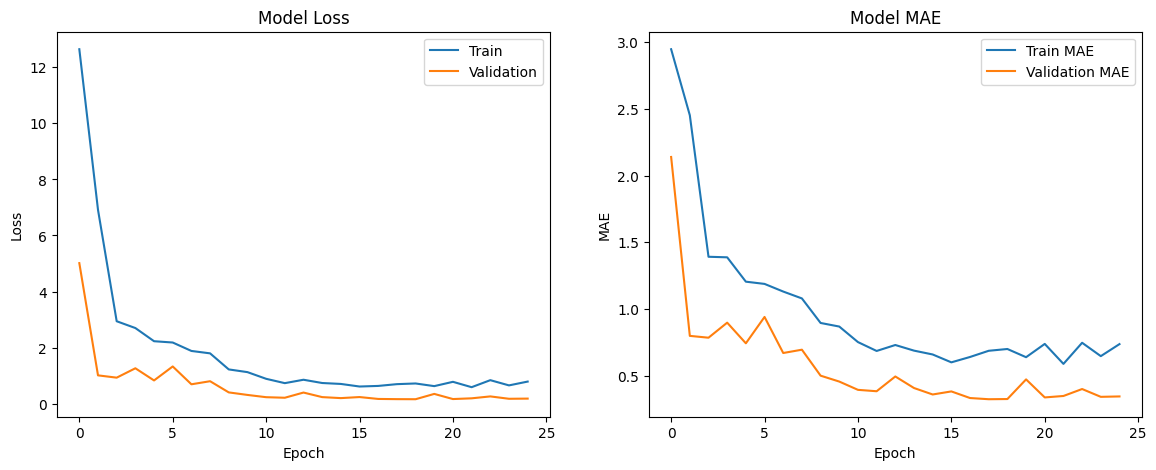

   Actual ONSD  Predicted ONSD  Absolute Error
0          6.0        4.969300        1.030700
1          4.9        5.203511        0.303511
2          4.9        5.063265        0.163265
3          5.4        4.978100        0.421900
4          4.9        4.807099        0.092901
5          4.8        5.188796        0.388796
6          5.9        5.127602        0.772398
7          5.2        4.621943        0.578057
8          4.7        5.156383        0.456383
9          5.0        4.913244        0.086756


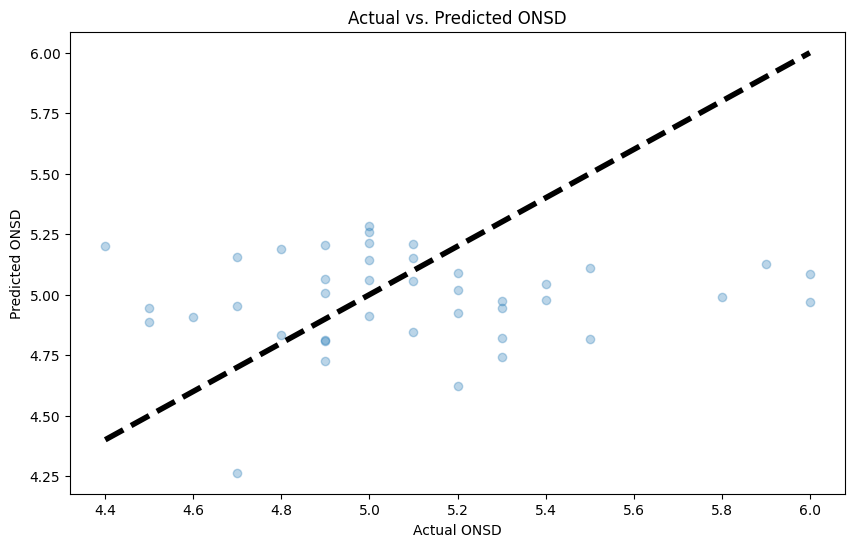

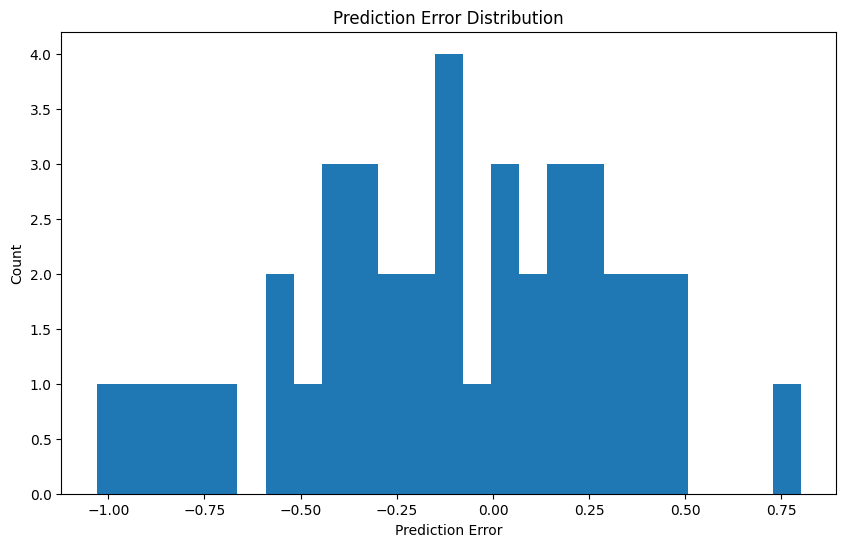

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the training history
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

# Assuming 'predictions' is a numpy array with the predicted ONSD values
# And 'y_test' is the actual ONSD measurements from the test set

# Convert predictions to a 1D array if it's not already
predictions = predictions.flatten()

# Create a DataFrame for a cleaner display
comparison_df = pd.DataFrame({'Actual ONSD': y_test, 'Predicted ONSD': predictions})

# Add a column for absolute error
comparison_df['Absolute Error'] = np.abs(comparison_df['Actual ONSD'] - comparison_df['Predicted ONSD'])

# Display several examples
print(comparison_df.head(10))

# Plotting Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('Actual ONSD')
plt.ylabel('Predicted ONSD')
plt.title('Actual vs. Predicted ONSD')
plt.show()

# Plotting the error distribution
errors = predictions - y_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=25)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()


Epoch 1/25


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - loss: 13.6469 - mae: 3.2813 - val_loss: 3.5713 - val_mae: 1.7434
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - loss: 3.9167 - mae: 1.7291 - val_loss: 3.9810 - val_mae: 1.6979
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - loss: 4.0725 - mae: 1.6415 - val_loss: 1.9696 - val_mae: 1.1943
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 2.8222 - mae: 1.4077 - val_loss: 1.8902 - val_mae: 1.1149
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - loss: 2.1542 - mae: 1.2053 - val_loss: 1.2447 - val_mae: 0.9004
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 1.8812 - mae: 1.1489 - val_loss: 1.2644 - val_mae: 0.9037
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 2.4095 - mae: 1.2578 - val_loss: 0.8319 - val_mae: 0.7146
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - loss: 1.4170 - mae: 0.9599 - val_loss: 0.4795 - val_mae: 0.5619
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.9319 - mae: 0.7763 - v

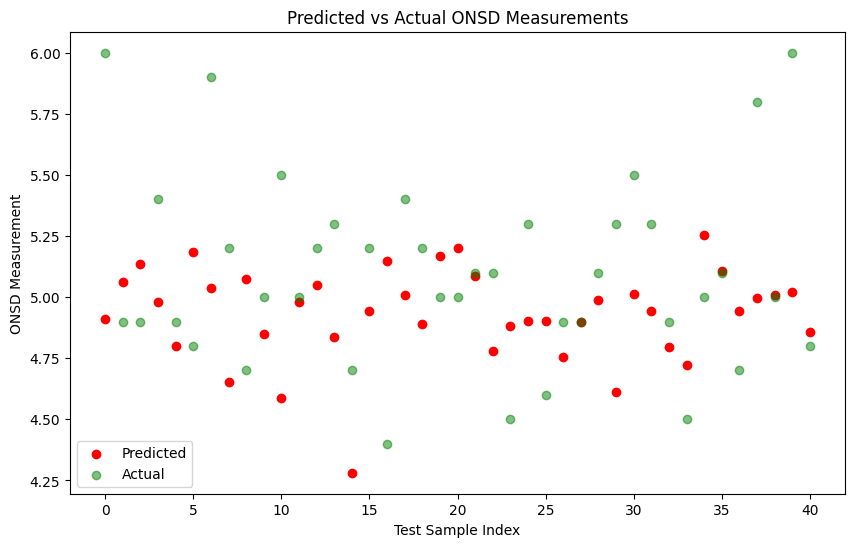

MAE: 0.3473794564968202, RMSE: 0.44585194329896466
               Model       MAE      RMSE
0  Linear Regression  0.341401  0.425412
1      Decision Tree  0.412195  0.534425
2      Random Forest  0.285826  0.369936
3            XGBoost  0.278263  0.360242


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Constants
image_dir = './documents'
preprocessed_dir = './documents/preprocessed_images'
left, top, img_width, img_height = 232, 60, 495, 475
right, bottom = left + img_width, top + img_height
crop_top, crop_height, crop_left, crop_width = 290, 100, 215, 125
crop_bottom, crop_right = crop_top + crop_height, crop_left + crop_width
MAX_FEATURES, GOOD_MATCH_PERCENT, MAX_DELTA = 500, 0.15, 200
MIN_DELTA_X, MAX_DELTA_X, MIN_DELTA_Y, MAX_DELTA_Y = -crop_left, img_width - crop_right, -crop_top, img_height - crop_bottom

# Create directories
os.makedirs(preprocessed_dir, exist_ok=True)

# Load and preprocess images
def load_and_preprocess_images(image_dir):
    image_files = os.listdir(image_dir)
    images = [(file, Image.open(os.path.join(image_dir, file)).convert('L')) for file in image_files if file.endswith(('.png', '.jpg', '.jpeg'))]
    cropped_images = [(file, img.crop((left, top, right, bottom))) for file, img in images]
    return [(file, np.array(image)) for file, image in cropped_images]

cv_images = load_and_preprocess_images(image_dir)

# Align images
def alignImages(im1, im2):
    try:
        im1Gray, im2Gray = (im1 if len(im1.shape) == 2 else cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)), (im2 if len(im2.shape) == 2 else cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY))
        orb = cv2.ORB_create(MAX_FEATURES)
        keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
        keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
        matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_L1)
        matches = sorted(list(matcher.match(descriptors1, descriptors2, None)), key=lambda x: x.distance)[:int(len(matches) * GOOD_MATCH_PERCENT)]

        if not matches:
            return (0, 0), np.array([]), [], None

        points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])
        deltas = points2 - points1
        deltas = deltas[(deltas[:, 0] > MIN_DELTA_X) & (deltas[:, 0] < MAX_DELTA_X) & (deltas[:, 1] > MIN_DELTA_Y) & (deltas[:, 1] < MAX_DELTA_Y)]

        if len(deltas) == 0:
            return (0, 0), np.array([]), [], None

        associations = DBSCAN(eps=10, min_samples=5).fit_predict(deltas)
        if len(np.unique(associations)) == 0 or (associations == -1).all():
            return (0, 0), np.array([]), [], None
        
        cluster_points = np.where(associations == 0)
        if len(cluster_points[0]) == 0:
            return (0, 0), np.array([]), [], None

        return np.average(deltas[cluster_points], axis=0), deltas, cluster_points, None
    except Exception as e:
        print(f"Exception occurred during alignment: {e}")
        return (0, 0), np.array([]), [], None

# Prepare image dataset
def prepare_image_dataset(cv_images):
    image_dataset = np.zeros((len(cv_images), crop_height, crop_width), dtype=np.uint8)
    for i, (filename, image) in enumerate(cv_images):
        preprocessed_path = os.path.join(preprocessed_dir, filename)
        if os.path.exists(preprocessed_path):
            continue

        offset_left, offset_top = alignImages(cv_images[0][1], image)[0]
        if np.isnan(offset_left) or np.isnan(offset_top):
            continue

        cropped_top, cropped_bottom = int(crop_top + offset_top), int(crop_bottom + offset_top)
        cropped_left, cropped_right = int(crop_left + offset_left), int(crop_right + offset_left)
        if (0 <= cropped_top < cropped_bottom <= image.shape[0]) and (0 <= cropped_left < cropped_right <= image.shape[1]):
            cropped_image = image[cropped_top:cropped_bottom, cropped_left:cropped_right]
            image_dataset[i] = cropped_image
            Image.fromarray(cropped_image).save(preprocessed_path)
    return image_dataset

image_dataset = prepare_image_dataset(cv_images)

# Load ONSD measurements and labels
def load_data(excel_file, preprocessed_dir):
    df = pd.read_excel(excel_file)
    df['filename'] = df['record_id'].astype(str) + '_image_data_' + df['redcap_repeat_instance'].astype(str) + '_raw_image.jpg'
    df['onsd'] = df['onsd'].astype(str).str.replace(',', '.').astype(float)
    images = []
    for _, row in df.iterrows():
        image_path = os.path.join(preprocessed_dir, row['filename'])
        try:
            with Image.open(image_path) as img:
                img = img.resize((128, 128))
                images.append(np.array(img))
        except FileNotFoundError:
            print(f"File not found: {image_path}")
    return np.array(images), df['onsd'].values

images, onsd_measurements = load_data('Meta_pic_3.xlsx', preprocessed_dir)

# Normalize images
images = images / 255.0
images = images.reshape(images.shape + (1,))

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, onsd_measurements, test_size=0.2, random_state=42)

# Build CNN model
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D((3, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    return model

model = build_model()
model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Train model
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

# Predictions
predictions = model.predict(X_test)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(predictions)), predictions, color='r', label='Predicted')
plt.scatter(range(len(y_test)), y_test, color='g', alpha=0.5, label='Actual')
plt.title('Predicted vs Actual ONSD Measurements')
plt.xlabel('Test Sample Index')
plt.ylabel('ONSD Measurement')
plt.legend()
plt.show()

# Error metrics
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"MAE: {mae}, RMSE: {rmse}")

# Model comparison
def model_comparison(X_train, y_train, X_test, y_test):
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8, random_state=42)
    }

    results = []
    for name, model in models.items():
        model.fit(X_train_flat, y_train)
        predictions = model.predict(X_test_flat)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        results.append((name, mae, rmse))

    return pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE'])

comparison_df = model_comparison(X_train, y_train, X_test, y_test)
print(comparison_df)

# Save comparison results
comparison_df.to_csv('model_comparison.csv', index=False)






In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define a function to build more complex CNN models
def build_complex_cnn(input_shape=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    return model

# Define a function to build and fine-tune pretrained models
def build_pretrained_model(base_model, input_shape=(128, 128, 3)):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Instantiate the pretrained models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vgg16_model = build_pretrained_model(vgg16_base)
resnet50_model = build_pretrained_model(resnet50_base)


In [ ]:
# Compile models
complex_cnn = build_complex_cnn(input_shape=(128, 128, 1))
complex_cnn.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

vgg16_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
resnet50_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])

# Train models
complex_cnn_history = complex_cnn.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))
vgg16_history = vgg16_model.fit(np.repeat(X_train, 3, axis=-1), y_train, epochs=25, validation_data=(np.repeat(X_test, 3, axis=-1), y_test))
resnet50_history = resnet50_model.fit(np.repeat(X_train, 3, axis=-1), y_train, epochs=25, validation_data=(np.repeat(X_test, 3, axis=-1), y_test))

# Evaluate models
complex_cnn_test_mae = complex_cnn.evaluate(X_test, y_test)[1]
vgg16_test_mae = vgg16_model.evaluate(np.repeat(X_test, 3, axis=-1), y_test)[1]
resnet50_test_mae = resnet50_model.evaluate(np.repeat(X_test, 3, axis=-1), y_test)[1]


Epoch 1/25


/workspaces/ONSD_Explore/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 622ms/step - loss: 21.6340 - mae: 4.0621 - val_loss: 13.9577 - val_mae: 3.7074
Epoch 2/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 585ms/step - loss: 17.0261 - mae: 4.0837 - val_loss: 18.5378 - val_mae: 4.2863
Epoch 3/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - loss: 15.1682 - mae: 3.8148 - val_loss: 2.6400 - val_mae: 1.3543
Epoch 4/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 563ms/step - loss: 4.8149 - mae: 1.7194 - val_loss: 1.7152 - val_mae: 1.1109
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 562ms/step - loss: 2.9777 - mae: 1.5034 - val_loss: 0.9103 - val_mae: 0.7650
Epoch 6/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 583ms/step - loss: 1.6553 - mae: 0.9819 - val_loss: 0.9732 - val_mae: 0.7859
Epoch 7/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 575ms/step - loss: 1.5315 - mae: 1.0045 - val_loss: 1.0544 - val_mae: 0.8417
Epoch 8/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 582ms/step - loss: 1.3949 - mae: 0.9462 - val_loss: 0.7494 - val_mae: 0.6851
Epoch 9/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step - loss: 1.3090 - mae: 0.9354

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f15502f09d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
               Model       MAE      RMSE
0         Simple CNN  0.344482  0.420724
1        Complex CNN  0.446768  0.565895
2     

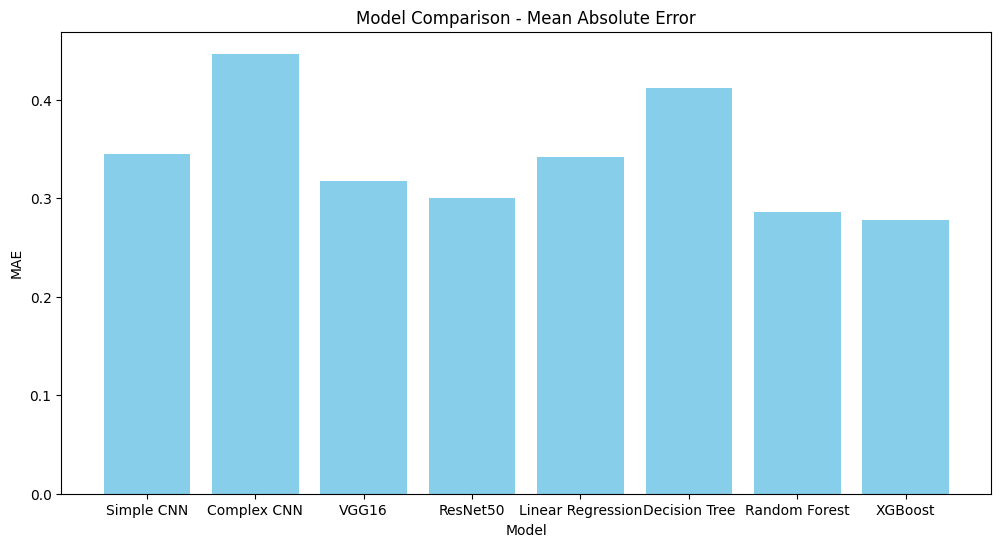

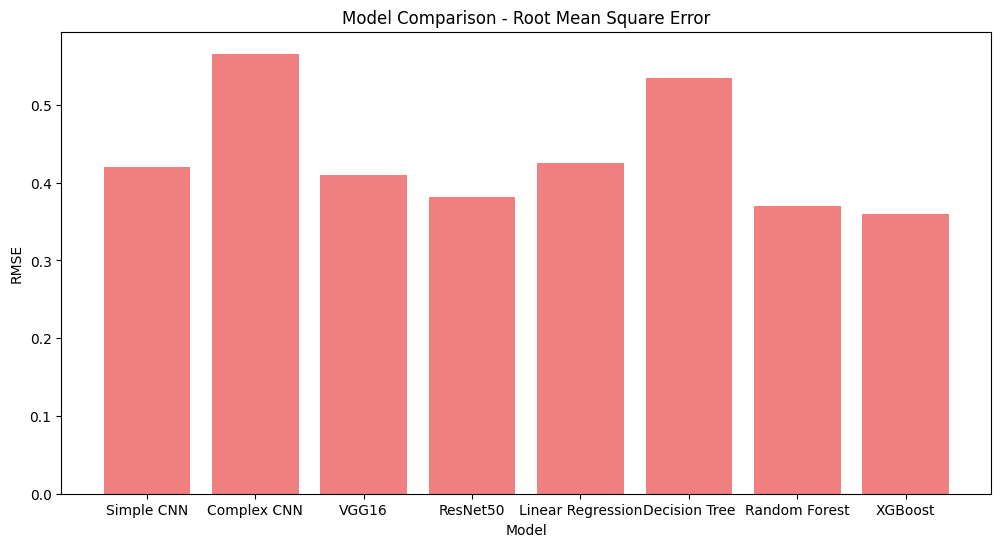

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Compute RMSE for the complex CNN, VGG16, and ResNet50 models
complex_cnn_predictions = complex_cnn.predict(X_test)
complex_cnn_rmse = np.sqrt(mean_squared_error(y_test, complex_cnn_predictions))

vgg16_predictions = vgg16_model.predict(np.repeat(X_test, 3, axis=-1))
vgg16_rmse = np.sqrt(mean_squared_error(y_test, vgg16_predictions))

resnet50_predictions = resnet50_model.predict(np.repeat(X_test, 3, axis=-1))
resnet50_rmse = np.sqrt(mean_squared_error(y_test, resnet50_predictions))

# These are your actual results
test_mae = 0.3444818682786895  # Simple CNN MAE
rmse = 0.42072380160686484    # Simple CNN RMSE

# Results for other models
mae_lr = 0.341401   # Linear Regression MAE
rmse_lr = 0.425412  # Linear Regression RMSE

mae_dt = 0.412195   # Decision Tree MAE
rmse_dt = 0.534425  # Decision Tree RMSE

mae_rf = 0.285826   # Random Forest MAE
rmse_rf = 0.369936  # Random Forest RMSE

mae_xgb = 0.278263  # XGBoost MAE
rmse_xgb = 0.360242 # XGBoost RMSE

# Model evaluation results
comparison_data = {
    'Model': ['Simple CNN', 'Complex CNN', 'VGG16', 'ResNet50', 'Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [test_mae, complex_cnn_test_mae, vgg16_test_mae, resnet50_test_mae, mae_lr, mae_dt, mae_rf, mae_xgb],
    'RMSE': [rmse, complex_cnn_rmse, vgg16_rmse, resnet50_rmse, rmse_lr, rmse_dt, rmse_rf, rmse_xgb]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

# Save comparison results
comparison_df.to_csv('model_comparison_expanded.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison - Root Mean Square Error')
plt.show()


               Model       MAE      RMSE
0         Simple CNN  0.344482  0.420724
1        Complex CNN  0.446768  0.565895
2              VGG16  0.318010  0.410475
3           ResNet50  0.299817  0.381566
4  Linear Regression  0.341401  0.425412
5      Decision Tree  0.412195  0.534425
6      Random Forest  0.285826  0.369936
7            XGBoost  0.278263  0.360242


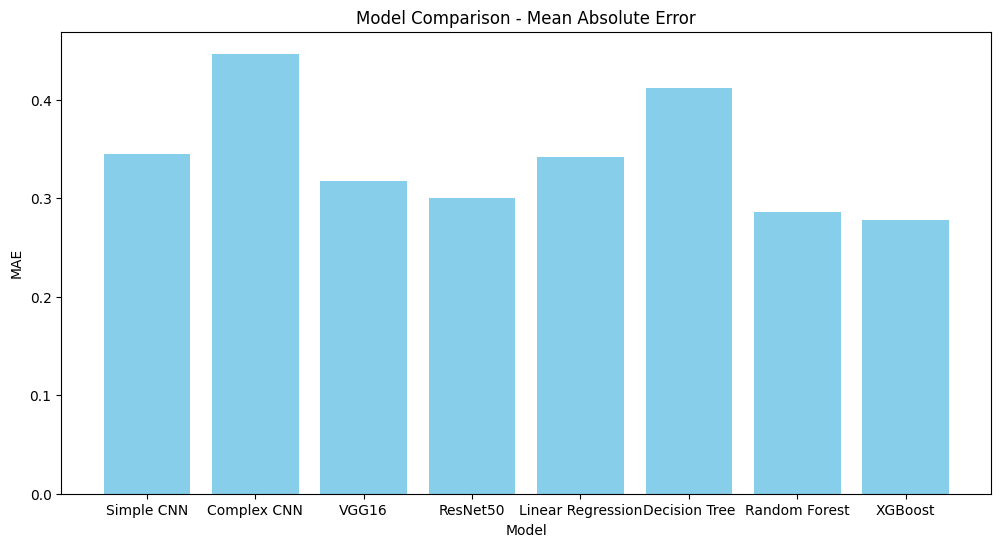

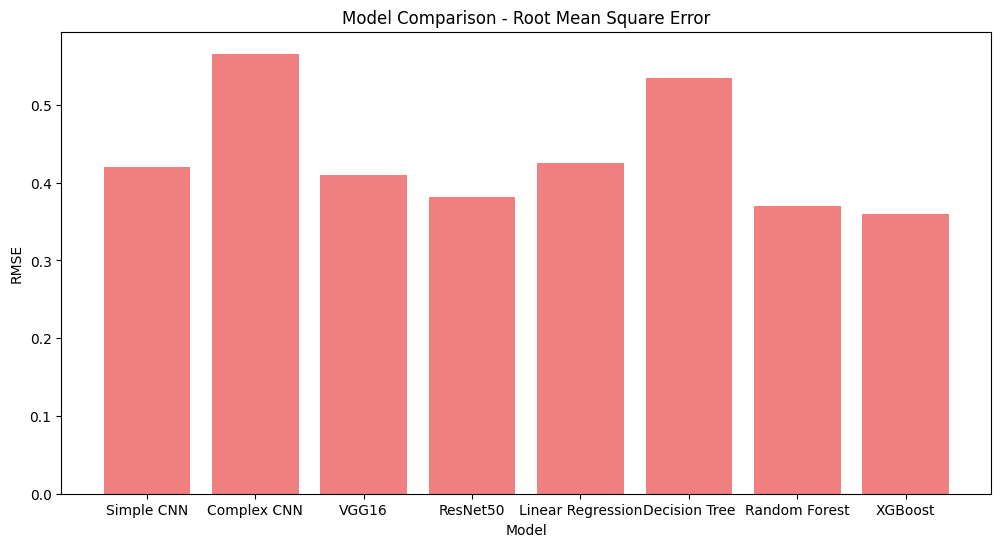

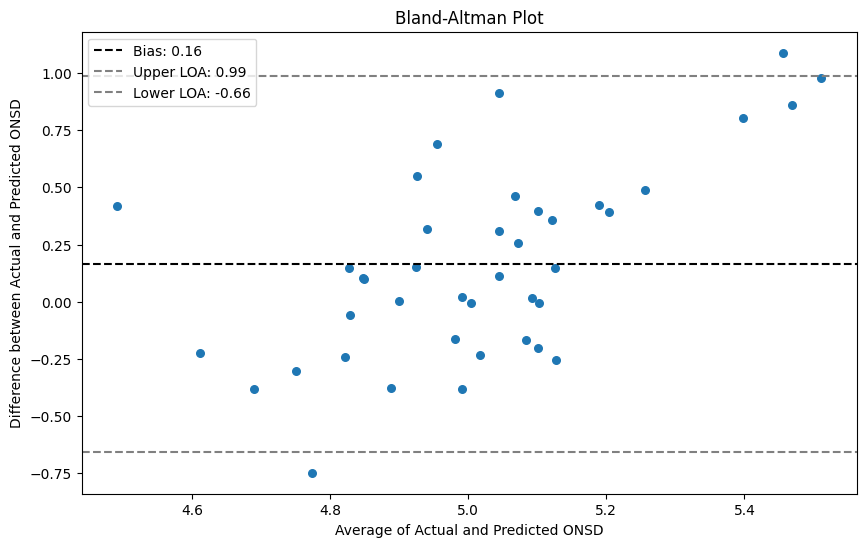

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Your existing code for data preprocessing and model evaluation goes here...

# Model evaluation results (example)
comparison_data = {
    'Model': ['Simple CNN', 'Complex CNN', 'VGG16', 'ResNet50', 'Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [test_mae, complex_cnn_test_mae, vgg16_test_mae, resnet50_test_mae, mae_lr, mae_dt, mae_rf, mae_xgb],
    'RMSE': [rmse, complex_cnn_rmse, vgg16_rmse, resnet50_rmse, rmse_lr, rmse_dt, rmse_rf, rmse_xgb]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)
comparison_df.to_csv('model_comparison_expanded.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison - Root Mean Square Error')
plt.show()

# Bland-Altman Plot

# Create a new DataFrame for the Bland-Altman plot
bland_altman_df = pd.DataFrame({
    'Actual ONSD': y_test,
    'Predicted ONSD': predictions.flatten()
})

# Calculate differences and averages
bland_altman_df['Difference'] = bland_altman_df['Actual ONSD'] - bland_altman_df['Predicted ONSD']
bland_altman_df['Average'] = (bland_altman_df['Actual ONSD'] + bland_altman_df['Predicted ONSD']) / 2

# Calculate bias and limits of agreement
bias = bland_altman_df['Difference'].mean()
std_dev = bland_altman_df['Difference'].std()
upper_loa = bias + 1.96 * std_dev
lower_loa = bias - 1.96 * std_dev

# Create the Bland-Altman plot
plt.figure(figsize=(10, 6))
plt.scatter(bland_altman_df['Average'], bland_altman_df['Difference'], s=30)
plt.axhline(bias, color='black', linestyle='--', label=f'Bias: {bias:.2f}')  # Bias line
plt.axhline(upper_loa, color='gray', linestyle='--', label=f'Upper LOA: {upper_loa:.2f}')  # Upper LOA
plt.axhline(lower_loa, color='gray', linestyle='--', label=f'Lower LOA: {lower_loa:.2f}')  # Lower LOA
plt.xlabel('Average of Actual and Predicted ONSD')
plt.ylabel('Difference between Actual and Predicted ONSD')
plt.title('Bland-Altman Plot')
plt.legend()

# Save the figure
plt.savefig('bland_altman_plot.png')

# Display the plot
plt.show()


               Model       MAE      RMSE
0         Simple CNN  0.344482  0.420724
1        Complex CNN  0.446768  0.565895
2              VGG16  0.318010  0.410475
3           ResNet50  0.299817  0.381566
4  Linear Regression  0.341401  0.425412
5      Decision Tree  0.412195  0.534425
6      Random Forest  0.285826  0.369936
7            XGBoost  0.278263  0.360242


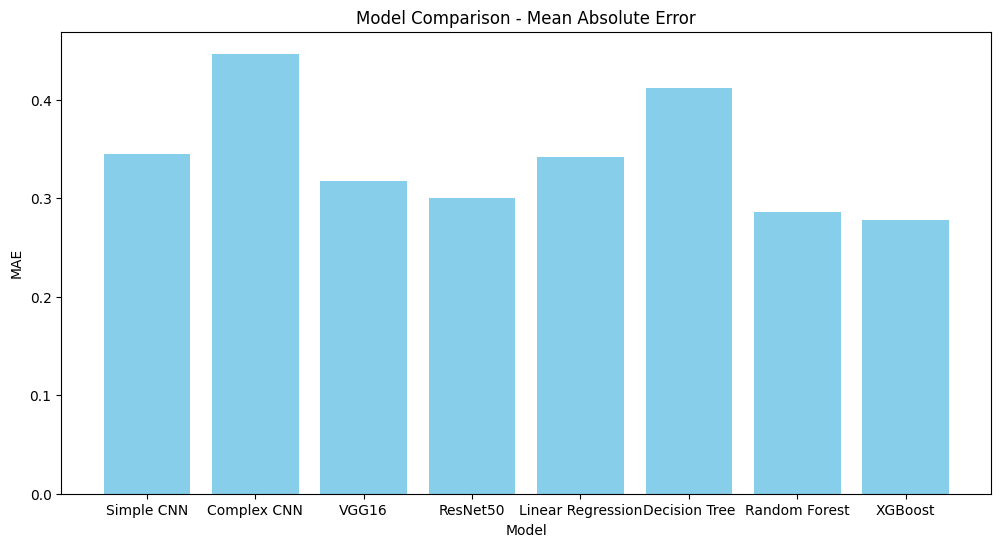

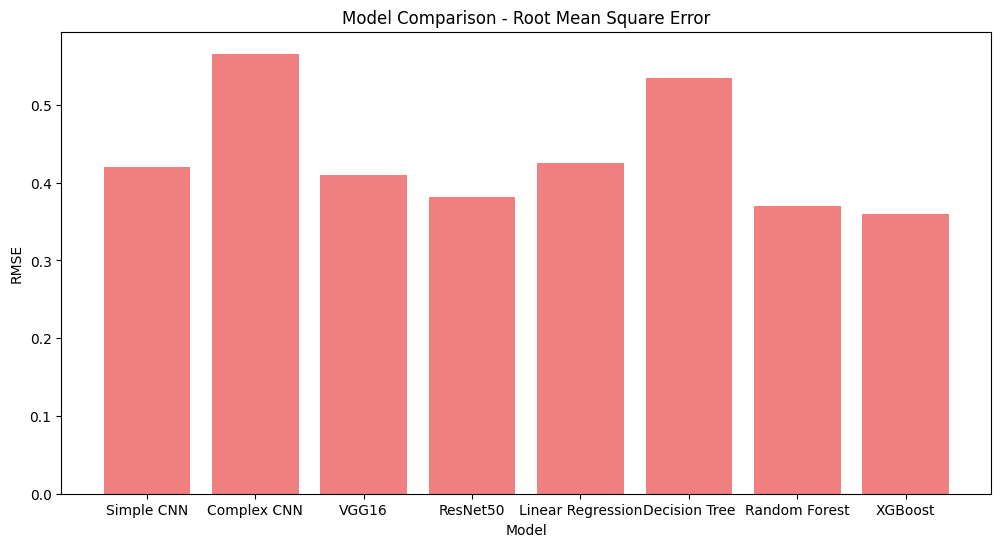

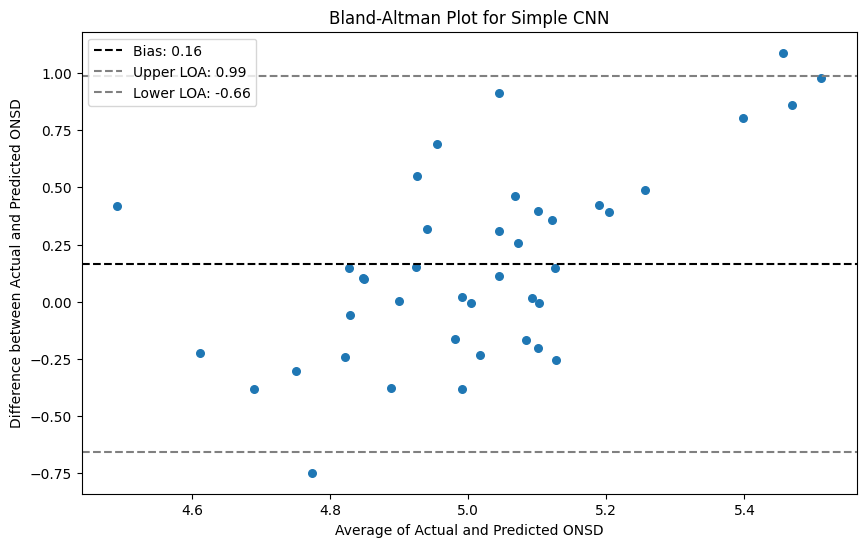

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Your existing code for data preprocessing and model evaluation goes here...

# Model evaluation results (example)
comparison_data = {
    'Model': ['Simple CNN', 'Complex CNN', 'VGG16', 'ResNet50', 'Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [test_mae, complex_cnn_test_mae, vgg16_test_mae, resnet50_test_mae, mae_lr, mae_dt, mae_rf, mae_xgb],
    'RMSE': [rmse, complex_cnn_rmse, vgg16_rmse, resnet50_rmse, rmse_lr, rmse_dt, rmse_rf, rmse_xgb]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)
comparison_df.to_csv('model_comparison_expanded.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison - Root Mean Square Error')
plt.show()

# Bland-Altman Plot for Simple CNN

# Assuming you have the 'y_test' and 'predictions' from the Simple CNN model

# Create a new DataFrame for the Bland-Altman plot
bland_altman_df = pd.DataFrame({
    'Actual ONSD': y_test,
    'Predicted ONSD': predictions.flatten()
})

# Calculate differences and averages
bland_altman_df['Difference'] = bland_altman_df['Actual ONSD'] - bland_altman_df['Predicted ONSD']
bland_altman_df['Average'] = (bland_altman_df['Actual ONSD'] + bland_altman_df['Predicted ONSD']) / 2

# Calculate bias and limits of agreement
bias = bland_altman_df['Difference'].mean()
std_dev = bland_altman_df['Difference'].std()
upper_loa = bias + 1.96 * std_dev
lower_loa = bias - 1.96 * std_dev

# Create the Bland-Altman plot
plt.figure(figsize=(10, 6))
plt.scatter(bland_altman_df['Average'], bland_altman_df['Difference'], s=30)
plt.axhline(bias, color='black', linestyle='--', label=f'Bias: {bias:.2f}')  # Bias line
plt.axhline(upper_loa, color='gray', linestyle='--', label=f'Upper LOA: {upper_loa:.2f}')  # Upper LOA
plt.axhline(lower_loa, color='gray', linestyle='--', label=f'Lower LOA: {lower_loa:.2f}')  # Lower LOA
plt.xlabel('Average of Actual and Predicted ONSD')
plt.ylabel('Difference between Actual and Predicted ONSD')
plt.title('Bland-Altman Plot for Simple CNN')
plt.legend()

# Save the figure
plt.savefig('bland_altman_plot_simple_cnn.png')

# Display the plot
plt.show()


               Model       MAE      RMSE
0         Simple CNN  0.344482  0.420724
1        Complex CNN  0.446768  0.565895
2              VGG16  0.318010  0.410475
3           ResNet50  0.299817  0.381566
4  Linear Regression  0.341401  0.425412
5      Decision Tree  0.412195  0.534425
6      Random Forest  0.285826  0.369936
7            XGBoost  0.278263  0.360242


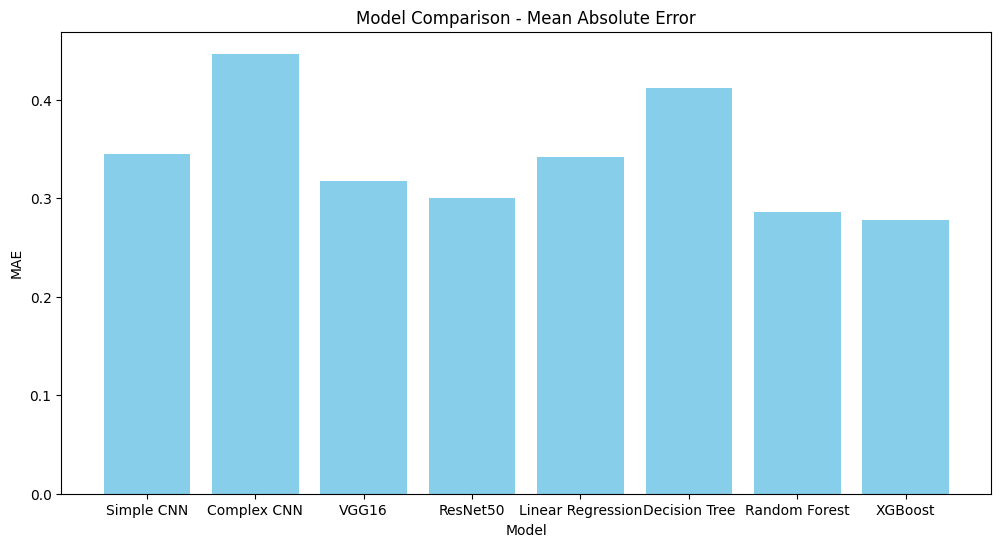

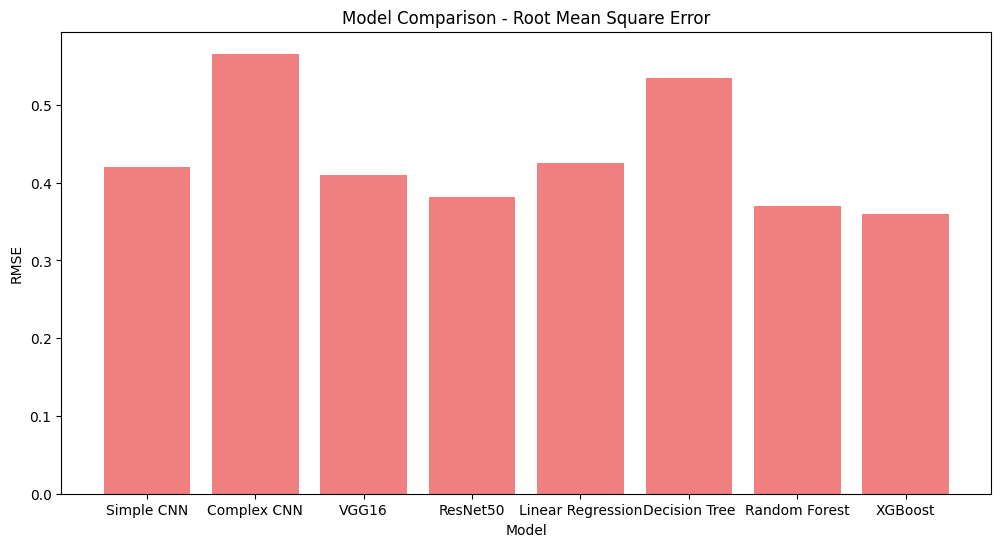

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step


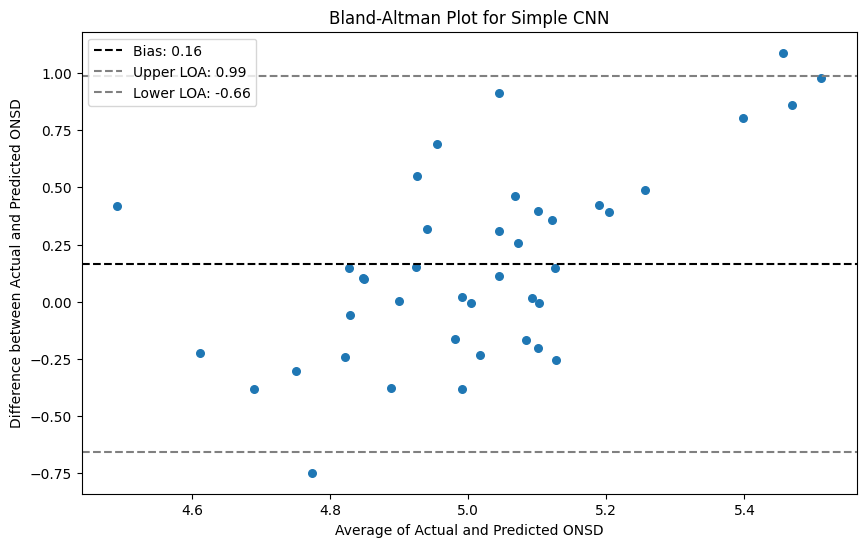

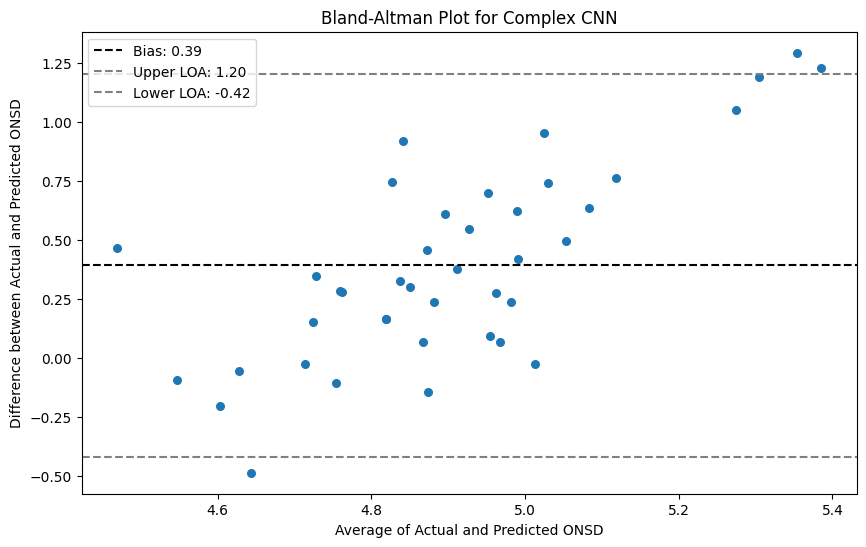

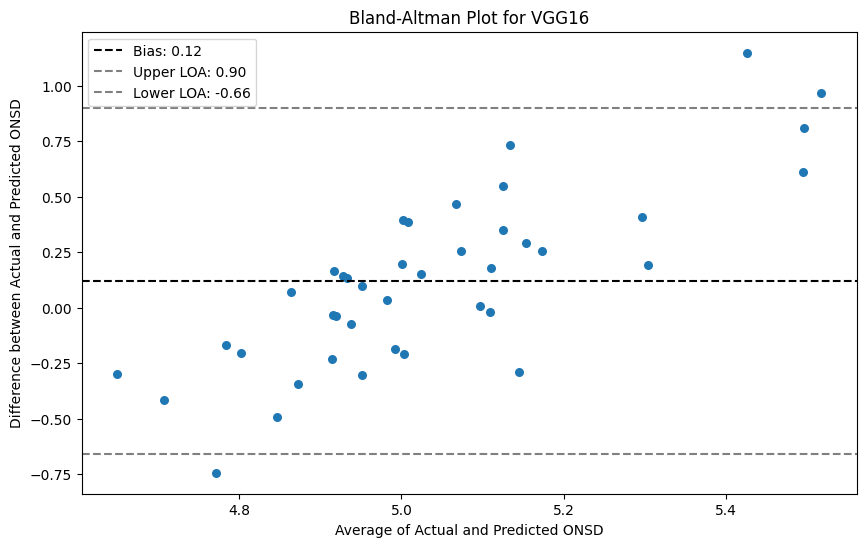

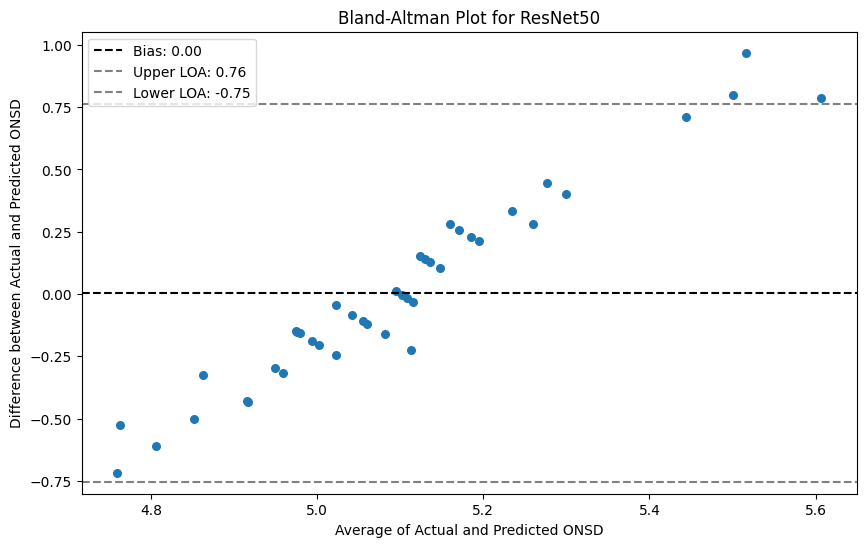

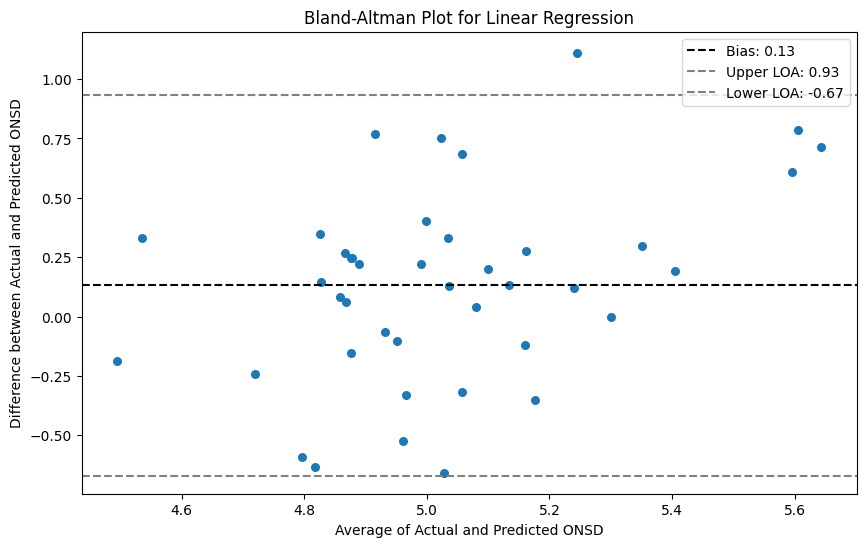

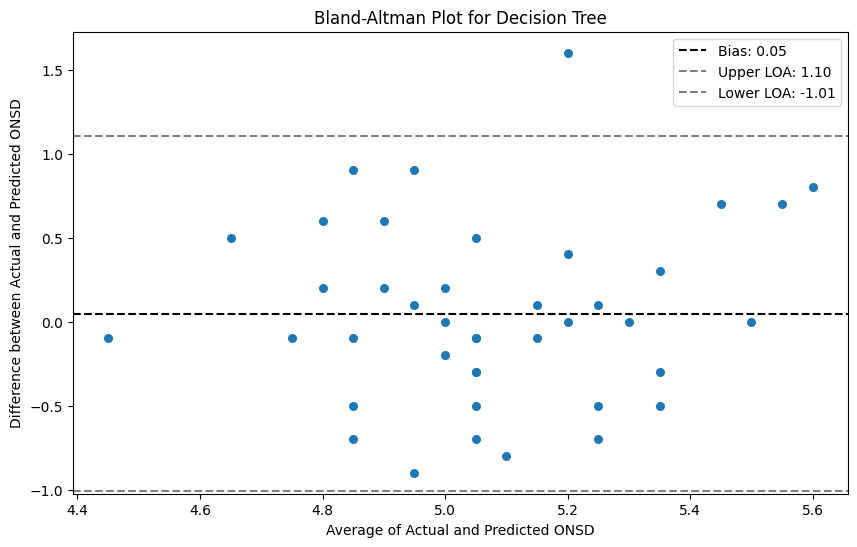

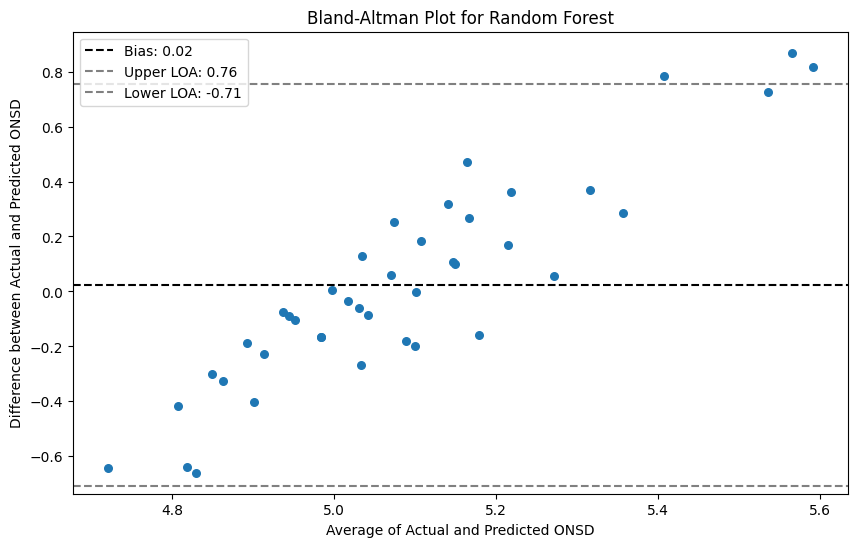

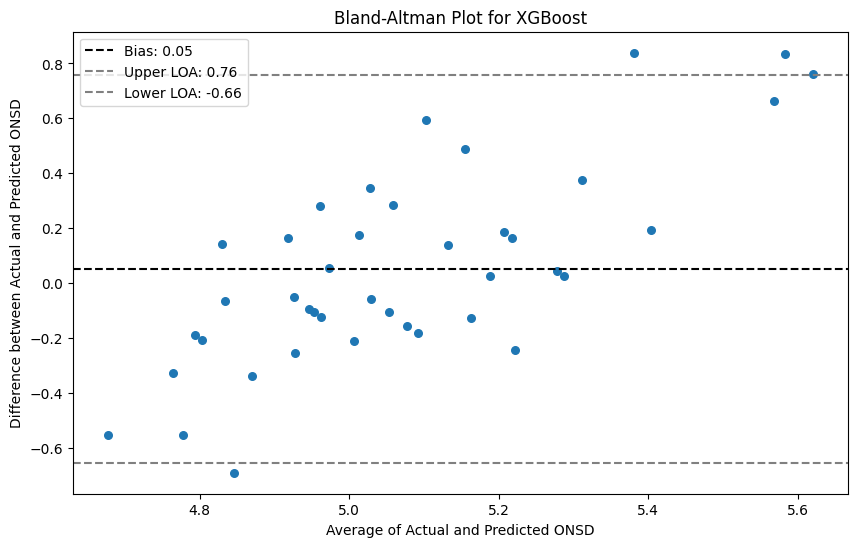

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Your existing code for data preprocessing and model evaluation goes here...

# Model evaluation results (example)
comparison_data = {
    'Model': ['Simple CNN', 'Complex CNN', 'VGG16', 'ResNet50', 'Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [test_mae, complex_cnn_test_mae, vgg16_test_mae, resnet50_test_mae, mae_lr, mae_dt, mae_rf, mae_xgb],
    'RMSE': [rmse, complex_cnn_rmse, vgg16_rmse, resnet50_rmse, rmse_lr, rmse_dt, rmse_rf, rmse_xgb]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)
comparison_df.to_csv('model_comparison_expanded.csv', index=False)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('Model Comparison - Mean Absolute Error')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='lightcoral')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Model Comparison - Root Mean Square Error')
plt.show()

# Bland-Altman Plots for all models

def bland_altman_plot(actual, predicted, model_name):
    # Create a new DataFrame for the Bland-Altman plot
    bland_altman_df = pd.DataFrame({
        'Actual ONSD': actual,
        'Predicted ONSD': predicted.flatten()
    })

    # Calculate differences and averages
    bland_altman_df['Difference'] = bland_altman_df['Actual ONSD'] - bland_altman_df['Predicted ONSD']
    bland_altman_df['Average'] = (bland_altman_df['Actual ONSD'] + bland_altman_df['Predicted ONSD']) / 2

    # Calculate bias and limits of agreement
    bias = bland_altman_df['Difference'].mean()
    std_dev = bland_altman_df['Difference'].std()
    upper_loa = bias + 1.96 * std_dev
    lower_loa = bias - 1.96 * std_dev

    # Create the Bland-Altman plot
    plt.figure(figsize=(10, 6))
    plt.scatter(bland_altman_df['Average'], bland_altman_df['Difference'], s=30)
    plt.axhline(bias, color='black', linestyle='--', label=f'Bias: {bias:.2f}')  # Bias line
    plt.axhline(upper_loa, color='gray', linestyle='--', label=f'Upper LOA: {upper_loa:.2f}')  # Upper LOA
    plt.axhline(lower_loa, color='gray', linestyle='--', label=f'Lower LOA: {lower_loa:.2f}')  # Lower LOA
    plt.xlabel('Average of Actual and Predicted ONSD')
    plt.ylabel('Difference between Actual and Predicted ONSD')
    plt.title(f'Bland-Altman Plot for {model_name}')
    plt.legend()

    # Save the figure
    plt.savefig(f'bland_altman_plot_{model_name}.png')

    # Display the plot
    plt.show()

# Predictions for each model (assuming you have already computed these predictions)
# Replace these with your actual prediction arrays
predictions_simple_cnn = model.predict(X_test)
predictions_complex_cnn = complex_cnn.predict(X_test)
predictions_vgg16 = vgg16_model.predict(np.repeat(X_test, 3, axis=-1))
predictions_resnet50 = resnet50_model.predict(np.repeat(X_test, 3, axis=-1))

# Linear Regression
lr_model = LinearRegression().fit(X_train.reshape(X_train.shape[0], -1), y_train)
predictions_lr = lr_model.predict(X_test.reshape(X_test.shape[0], -1))

# Decision Tree
dt_model = DecisionTreeRegressor(random_state=42).fit(X_train.reshape(X_train.shape[0], -1), y_train)
predictions_dt = dt_model.predict(X_test.reshape(X_test.shape[0], -1))

# Random Forest
rf_model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=42).fit(X_train.reshape(X_train.shape[0], -1), y_train)
predictions_rf = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# XGBoost
xgb_model = XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8, random_state=42).fit(X_train.reshape(X_train.shape[0], -1), y_train)
predictions_xgb = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# Create Bland-Altman plots for each model
bland_altman_plot(y_test, predictions_simple_cnn, "Simple CNN")
bland_altman_plot(y_test, predictions_complex_cnn, "Complex CNN")
bland_altman_plot(y_test, predictions_vgg16, "VGG16")
bland_altman_plot(y_test, predictions_resnet50, "ResNet50")
bland_altman_plot(y_test, predictions_lr, "Linear Regression")
bland_altman_plot(y_test, predictions_dt, "Decision Tree")
bland_altman_plot(y_test, predictions_rf, "Random Forest")
bland_altman_plot(y_test, predictions_xgb, "XGBoost")


In [ ]:
import json
import numpy as np

# Assuming X_train_flat and y_train are already defined from your ONSD data
# Replace this with the actual data loading and preprocessing steps

# Example placeholder code (replace with your actual data)
# X_train_flat = ...  # Your ONSD image features
# y_train = ...       # Your ONSD image labels

# Combine the features and labels into a single array
data = np.hstack((X_train_flat, y_train.reshape(-1, 1)))

# Save the data to a JSON file
with open('data.json', 'w') as f:
    json.dump(data.tolist(), f)




NameError: name 'X_train_flat' is not defined